In [24]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.optimize import minimize

from qiskit_aer.noise import (
    NoiseModel,
    amplitude_damping_error,
    phase_damping_error,
    depolarizing_error,
    thermal_relaxation_error
)

from qiskit_aer import AerSimulator
from qiskit_optimization.applications import Maxcut
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.circuit.library.n_local.qaoa_ansatz import QAOAAnsatz
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator 
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


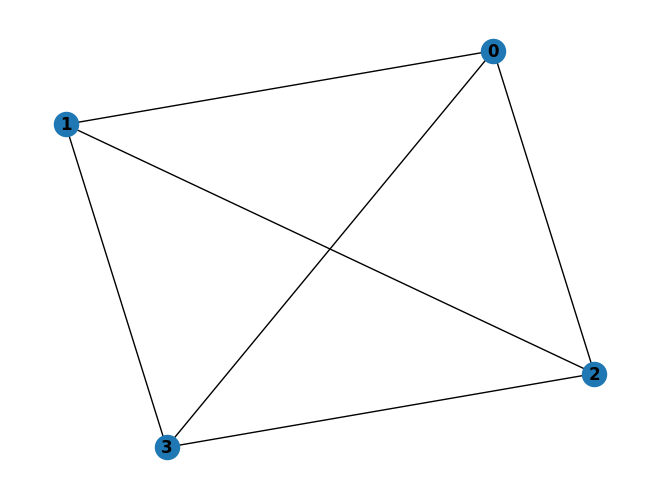

In [25]:

n = 4
p = 1
G = nx.erdos_renyi_graph(n, 1)
for (u,v) in G.edges():
    G[u][v]['weight'] = 1.0

edges = G.edges()
nx.draw(G, with_labels=True, font_weight='bold')
w = np.zeros([n,n])
for (u,v) in G.edges():
    w[u][v] = G[u][v]['weight']
    w[v][u] = G[u][v]['weight']
#print(w)


In [26]:
prob=Maxcut(w)
qp = prob.to_quadratic_program()
print(qp.prettyprint())
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
print(qubo.prettyprint())

cost_hamiltonian, offset = qubo.to_ising()
print(offset)
print(cost_hamiltonian)

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_1*x_3 - 2*x_2*x_3 + 3*x_0
  + 3*x_1 + 3*x_2 + 3*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3

Problem name: Max-cut

Minimize
  2*x_0*x_1 + 2*x_0*x_2 + 2*x_0*x_3 + 2*x_1*x_2 + 2*x_1*x_3 + 2*x_2*x_3 - 3*x_0
  - 3*x_1 - 3*x_2 - 3*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3

-3.0
SparsePauliOp(['IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


In [27]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    return cost

In [28]:
# Coherence times (in nanoseconds)
T1 = 5*45e3  # relaxation time (amplitude damping error)
T2 = 6*20e3  # dephasing time (phase damping error)

# Time taken by different gates
u1 = 0.0  # RZ(gamma) gate (Virtual gate) 
u2 = 60  # Hadamard Gate
u3 = 120  # RX(beta) gate
cx = 720  # CNOT gate (2-qubit gate)

# gate error probability (Depolarizing Error)
err_1q = 1.5e-3  # 1-qubit gate error
err_2q = 4e-2  # 2-qubit gate error

In [29]:
total_execution_time = (p*(len(edges)*cx*2+ n*u3)+ n*u2)                    
t = total_execution_time

In [30]:
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
circuit.measure_all()

In [31]:
beta = np.linspace(0, 2*np.pi, 100)
gamma = np.linspace(0, 2*np.pi, 100)

In [32]:
# T1 error
p_t1 = 1 - np.exp(-t / T1)
error_t1 = amplitude_damping_error(p_t1)  # 1-qubit T1 error
error_t1_cx = amplitude_damping_error(p_t1).tensor(amplitude_damping_error(p_t1))  # 2-qubit T1 error

# T2 error
p_t2 = 1 - np.exp(-t / T2)
error_t2 = phase_damping_error(p_t2)
error_t2_cx = phase_damping_error(p_t2).tensor(phase_damping_error(p_t2))

# gate error
error_1q = depolarizing_error(err_1q, num_qubits=1)  # 1-qubit gate error
error_2q = depolarizing_error(err_2q, num_qubits=2)  # 2-qubit gate error

error_1q_all = error_t1.compose(error_t2).compose(error_1q)
error_2q_all = error_t1_cx.compose(error_t2_cx).compose(error_2q)

noise_all = NoiseModel()
noise_all.add_all_qubit_quantum_error(error_1q_all, ['u1', 'u2', 'u3'])
noise_all.add_all_qubit_quantum_error(error_2q_all, ['cx'])

sim_all = AerSimulator(noise_model = noise_all)
pm1 = generate_preset_pass_manager(optimization_level=3,backend=sim_all)
candidate_circuit1 = pm1.run(circuit)


AA = np.zeros([len(beta), len(gamma)])

for ii in range(0, len(beta), 1):
    for jj in range(0, len(gamma), 1):
        with Session(backend=sim_all) as session:  
            estimator = Estimator(mode=session)  
            estimator.options.default_shots = 100000  
            result1 = cost_func_estimator([beta[ii], gamma[jj]],
                                          candidate_circuit1, 
                                          cost_hamiltonian, 
                                          estimator)
        AA[jj][ii] = result1+offset

In [33]:
sim_ideal = AerSimulator()
pm2 = generate_preset_pass_manager(optimization_level=3,backend=sim_ideal)
candidate_circuit2 = pm2.run(circuit)

BB = np.zeros([len(beta), len(gamma)])

for ii in range(0, len(beta), 1):
    for jj in range(0, len(gamma), 1):
        with Session(backend=sim_ideal) as session:  
            estimator = Estimator(mode=session)  
            estimator.options.default_shots = 100000  
            result2 = cost_func_estimator([beta[ii], gamma[jj]],
                                          candidate_circuit2, 
                                          cost_hamiltonian, 
                                          estimator)
        BB[jj][ii] = result2+offset

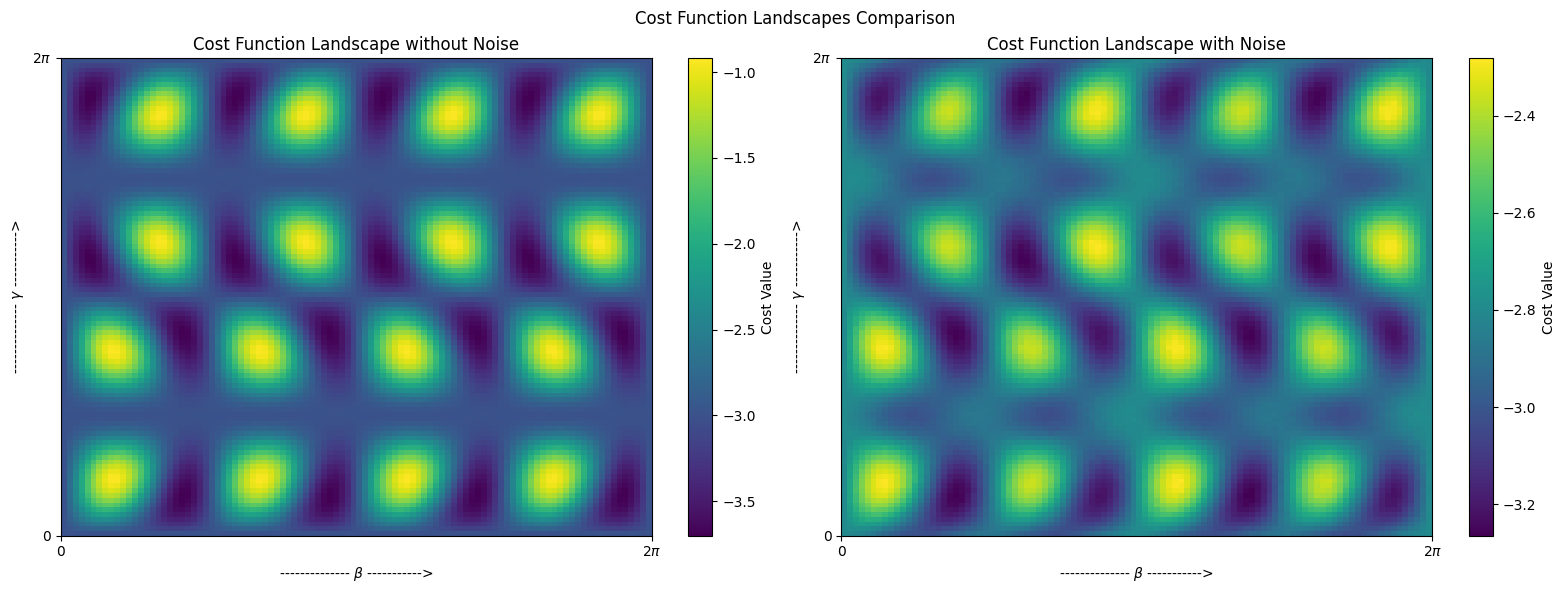

In [35]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)

plt.tight_layout()
plt.imshow(BB, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Cost Value')
plt.xlabel('-------------- $\\beta$ ----------->')
plt.ylabel('-------------- $\\gamma$ ----------->')
plt.xticks([0, 2*np.pi], ['0', '2$\\pi$'])
plt.yticks([0, 2*np.pi], ['0', '2$\\pi$'])
plt.title('Cost Function Landscape without Noise')

plt.subplot(1, 2, 2)
plt.tight_layout()
plt.imshow(AA, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Cost Value')
plt.xlabel('-------------- $\\beta$ ----------->')
plt.ylabel('-------------- $\\gamma$ ----------->')
plt.title('Cost Function Landscape with Noise')
plt.suptitle('Cost Function Landscapes Comparison')
plt.xticks([0, 2*np.pi], ['0', '2$\\pi$'])
plt.yticks([0, 2*np.pi], ['0', '2$\\pi$'])
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig('cost_function_landspace.pdf', dpi=300, bbox_inches='tight')
plt.show()